# Ride Price Estimation System (ML)

This notebook demonstrates a **complete ML workflow** for estimating ride prices using a small synthetic dataset.

**You will build:**
- A **Regression** model to predict the exact `ride_price`
- A **Classification** model to predict whether a ride is `high_cost` or not

## 1) Problem Framing

### 1️⃣ What is the problem?
> Estimate ride price based on trip and contextual features.

### 2️⃣ Why ML instead of fixed rules?
- Pricing depends on multiple interacting factors (distance, time, traffic, demand, weather).
- Fixed rules can be brittle and fail to capture combinations (e.g., **rainy + high demand + night**).
- ML can learn patterns from data and generalize to new trips.

### 3️⃣ What is the model learning?
> The relationship between trip conditions and the final ride price.

In [1]:
# Imports
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix

plt.style.use('seaborn-v0_8')
sns.set_context('notebook')
pd.set_option('display.max_columns', 50)

In [2]:
# Load dataset
# Notebook is in notebooks/, dataset is in data/
data_path = Path('..') / 'data' / 'ride_prices_synthetic.csv'
if not data_path.exists():
    data_path = Path('data') / 'ride_prices_synthetic.csv'

df = pd.read_csv(data_path)
print('Loaded:', data_path.resolve())
df.head()

Loaded: C:\Users\HP\Documents\programming\AIML\GDSC_study_session_ML_g1\Ride_Price_Estimation_System\data\ride_prices_synthetic.csv


,distance_km,duration_min,traffic_level,weather,time_of_day,demand_level,passengers,ride_price
0,21.85,48.1,medium,clear,evening,high,4,1427.21
1,12.74,32.4,high,rainy,evening,low,1,860.38
2,24.15,57.4,medium,rainy,night,high,2,1774.19
3,19.77,NaN,low,clear,evening,low,2,803.31
4,3.36,7.8,low,rainy,night,low,4,378.31


## 2) Quick EDA (Exploration)
We’ll inspect the schema, summary stats, missing values, and at least one visualization.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    194 non-null    float64
 1   duration_min   194 non-null    float64
 2   traffic_level  194 non-null    object 
 3   weather        192 non-null    object 
 4   time_of_day    198 non-null    object 
 5   demand_level   197 non-null    object 
 6   passengers     200 non-null    int64  
 7   ride_price     200 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 12.6+ KB


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
distance_km,194.0,NaN,NaN,NaN,14.282062,8.088706,1.0,7.4525,13.83,20.9375,50.32
duration_min,194.0,NaN,NaN,NaN,32.92268,16.841123,3.0,19.225,33.95,43.775,94.3
traffic_level,194,3,low,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,192,2,clear,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,198,3,morning,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
demand_level,197,2,low,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passengers,200.0,NaN,NaN,NaN,2.625,1.024511,1.0,2.0,3.0,3.0,4.0
ride_price,200.0,NaN,NaN,NaN,826.7068,399.242689,145.12,485.9075,821.905,1050.75,2006.61


In [5]:
# Missing values + unique categories
display(df.isna().sum().sort_values(ascending=False))

cat_cols = ['traffic_level', 'weather', 'time_of_day', 'demand_level']
for c in cat_cols:
    print(c, 'unique:', df[c].dropna().unique())

weather          8
distance_km      6
duration_min     6
traffic_level    6
demand_level     3
time_of_day      2
passengers       0
ride_price       0
dtype: int64

traffic_level unique: ['medium' 'high' 'low']
weather unique: ['clear' 'rainy']
time_of_day unique: ['evening' 'night' 'morning']
demand_level unique: ['high' 'low']


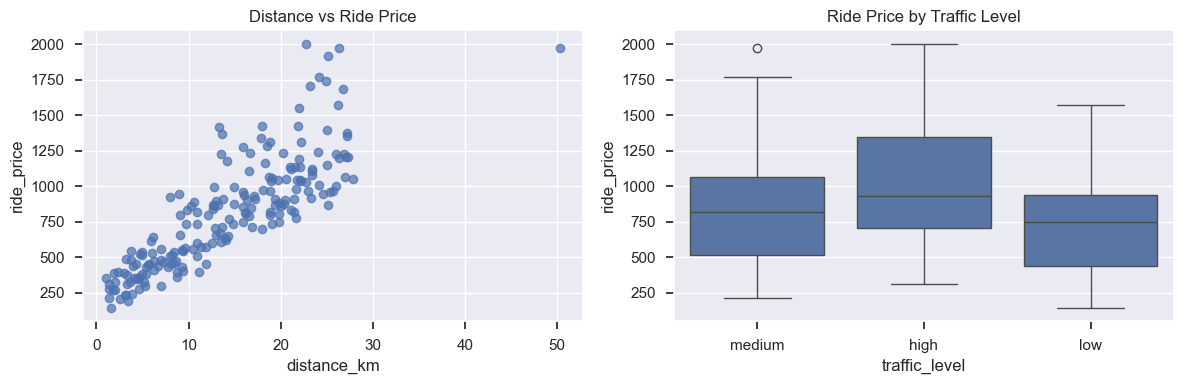

In [6]:
# Visualization (minimum 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df['distance_km'], df['ride_price'], alpha=0.7)
axes[0].set_title('Distance vs Ride Price')
axes[0].set_xlabel('distance_km')
axes[0].set_ylabel('ride_price')

sns.boxplot(data=df, x='traffic_level', y='ride_price', ax=axes[1])
axes[1].set_title('Ride Price by Traffic Level')
axes[1].set_xlabel('traffic_level')
axes[1].set_ylabel('ride_price')

plt.tight_layout()
plt.show()

## 3) Data Cleaning & Preprocessing
**Why it matters:** Poor data causes biased models and unstable predictions.

We will:
- Handle missing values
- Clip extreme outliers (IQR method)
- One-hot encode categorical features using `pd.get_dummies(drop_first=True)`
- Scale numeric features using `StandardScaler` (fit on train only to avoid leakage)

In [7]:
df_clean = df.copy()

numeric_cols = ['distance_km', 'duration_min', 'passengers']
categorical_cols = ['traffic_level', 'weather', 'time_of_day', 'demand_level']

# 1) Handle missing values
for c in numeric_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in categorical_cols:
    mode_val = df_clean[c].mode(dropna=True)
    fill_val = mode_val.iloc[0] if len(mode_val) else 'unknown'
    df_clean[c] = df_clean[c].fillna(fill_val)

# 2) Outlier handling via IQR clipping (features only)
def clip_iqr(s: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return s.clip(low, high)

for c in ['distance_km', 'duration_min']:
    df_clean[c] = clip_iqr(df_clean[c])

df_clean.isna().sum()

distance_km      0
duration_min     0
traffic_level    0
weather          0
time_of_day      0
demand_level     0
passengers       0
ride_price       0
dtype: int64

In [8]:
# 3) Encode categoricals
df_model = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

X = df_model.drop(columns=['ride_price'])
y = df_model['ride_price']

X.head()

,distance_km,duration_min,passengers,traffic_level_low,traffic_level_medium,weather_rainy,time_of_day_morning,time_of_day_night,demand_level_low
0,21.85,48.10,4,False,True,False,False,False,False
1,12.74,32.40,1,False,False,True,False,False,True
2,24.15,57.40,2,False,True,True,False,True,False
3,19.77,33.95,2,True,False,False,False,False,True
4,3.36,7.80,4,True,False,True,False,True,True


## 4) Regression Model (Linear Regression)
We train a baseline regression model to predict the exact `ride_price`.

Evaluation metrics:
- **MAE** (mean absolute error)
- **$R^2$** score

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features only (dummies are left as-is)
numeric_cols_after = ['distance_km', 'duration_min', 'passengers']

preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_cols_after)],
    remainder='passthrough'
)

reg_model = Pipeline(steps=[('preprocess', preprocess), ('model', LinearRegression())])
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'R^2: {r2:.3f}')

MAE: 70.72
R^2: 0.954


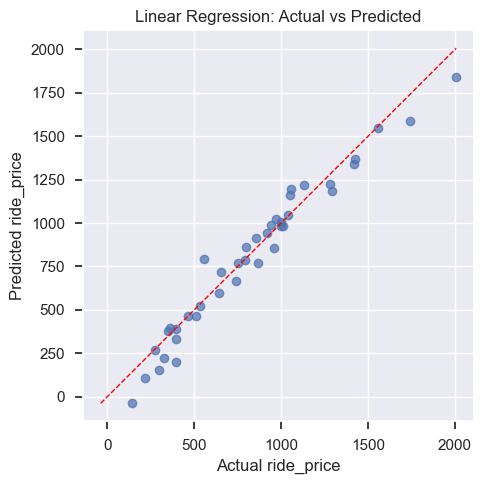

In [10]:
# Plot predictions
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual ride_price')
plt.ylabel('Predicted ride_price')
plt.title('Linear Regression: Actual vs Predicted')

min_v = float(min(y_test.min(), y_pred.min()))
max_v = float(max(y_test.max(), y_pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.tight_layout()
plt.show()

## 5) Classification Model (Logistic Regression)
We convert the problem into a simpler decision: **expensive vs cheap**.

We define:
- `high_cost = 1` if `ride_price` is above the dataset median
- else `high_cost = 0`

Logistic Regression outputs a **probability**. If probability > 0.5, we classify as class 1.

In [11]:
# Create binary target
median_price = float(y.median())
y_class = (y > median_price).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

clf_model = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', LogisticRegression(max_iter=1000))
    ]
)

clf_model.fit(X_train_c, y_train_c)
y_pred_c = clf_model.predict(X_test_c)

acc = accuracy_score(y_test_c, y_pred_c)
cm = confusion_matrix(y_test_c, y_pred_c)

print(f'Accuracy: {acc:.3f}')
print('Confusion matrix:\n', cm)

Accuracy: 0.975
Confusion matrix:
 [[20  0]
 [ 1 19]]


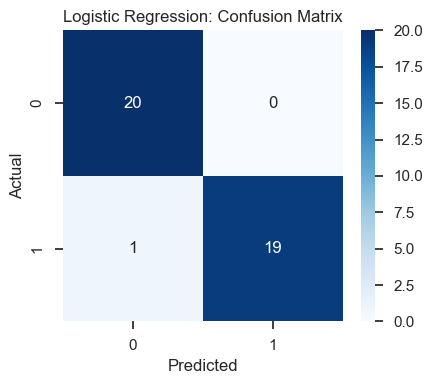

In [12]:
# Confusion matrix plot
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression: Confusion Matrix')
plt.tight_layout()
plt.show()

## 6) Compare the Two Approaches
- **Regression** predicts the exact price value → more detailed output.
- **Classification** predicts expensive vs cheap → easier for decisions (e.g., show warnings, apply rules).
- Regression is often preferred when you need an exact quote; classification is helpful when you need a simple category.

## 7) Ethical Reflection & Limitations
- **Unfair pricing:** surge-like pricing can disproportionately impact low-income riders or neighborhoods.
- **Real-world risk:** model errors could overcharge customers or underpay drivers.
- **Dataset limitation:** this dataset is synthetic, so it may not represent real-world geographic and behavioral patterns.